In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, accuracy_score
from sklearn.preprocessing import label_binarize
import numpy as np
from itertools import cycle

In [26]:
# Set random seed for reproducibility
np.random.seed(42)

In [27]:
# 1. Load and prepare data
df = pd.read_csv('../Preprocessing/balanced_ecg_data.csv')  # Your balanced dataset
#df = pd.read_csv('./diagnostic_classes.csv')
df.head()

,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,Feature10,...,Feature21,Feature22,Feature23,Feature24,Feature25,Feature26,Feature27,Feature28,Feature29,target
0,-1.944044,1.891310,5.378017,-1.099764,0.319998,-0.107990,0.192998,-0.531588,-1.978358,0.505306,...,0.435838,-0.375777,-2.410484,1.307302,-0.447091,-1.205613,-0.758668,-1.115528,1.219782,8
1,0.548890,3.689146,-1.079215,-1.125497,6.892610,-0.114086,-0.129833,-4.471123,1.281707,2.509007,...,-0.515136,-1.814937,-0.659753,0.092014,1.173449,-0.887015,-0.657684,0.676340,0.379053,8
2,1.044743,2.804073,-1.779122,-0.358211,6.132624,-1.309396,-0.731316,-3.381683,-1.444734,3.028355,...,-0.928873,-1.592203,-0.389953,0.343527,0.740160,-0.244341,-1.337129,-0.168281,-0.464880,8
3,-2.848743,-2.220174,-0.498797,-0.054547,0.073406,0.927517,1.891807,-0.381548,0.017551,0.659493,...,0.662054,0.671306,-0.463003,-0.170516,0.249816,0.019505,-0.380889,-0.222127,0.364851,8
4,-0.715628,0.217362,2.032461,-0.144826,4.375660,-1.762026,1.335940,1.742721,-1.771379,0.819612,...,-0.428352,-0.511074,-0.346423,0.137622,-0.289325,-1.089344,-0.407556,-0.007071,0.117600,8


In [28]:
df['target'].value_counts()

target
8     367
3     367
13    367
2     367
4     367
5     367
14    367
6     367
10    367
1     367
11    367
7     367
0     367
12    367
9     367
Name: count, dtype: int64

In [29]:
# Separate features and target
X = df.drop('target', axis=1)
y = df['target']

In [30]:
# 2. Split data (stratified for class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y  # Preserve class distribution
)

In [31]:
# 3. Feature scaling (essential for K-means)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [32]:
# 4. Initialize and train KMeans Clustering model
kmeans = KMeans(
    n_clusters=15,        # 15 clusters (assuming 15 classes)
    init='k-means++',     # Smart centroid initialization
    max_iter=300,         # Ensures convergence
    random_state=42,      # Reproducibility
    n_init=10             # Number of times k-means runs with different centroid seeds
)   

In [33]:
# Fit K-means on training data and predict clusters on test data
kmeans.fit(X_train_scaled)
y_pred_train = kmeans.predict(X_train_scaled)
y_pred_test = kmeans.predict(X_test_scaled)

In [34]:
# 5. Map K-means cluster labels to actual class labels
# Since K-means assigns arbitrary cluster labels, we need to map them to true labels
#Using the most frequent true label in each cluster for mapping
def map_clusters_to_labels(y_true, y_cluster):
    y_true = pd.Series(y_true)  # Ensure y_true is a pandas Series
    mapping = {}
    for cluster in np.unique(y_cluster):  # Iterate only over existing clusters
        mask = (y_cluster == cluster)
        if mask.sum() > 0:  # Ensure cluster is not empty
            most_common = y_true[mask].mode().iloc[0]  # Handle multiple modes safely
            mapping[cluster] = most_common
    # Map cluster predictions to true labels
    y_mapped = np.array([mapping.get(cluster, -1) for cluster in y_cluster])
    return y_mapped

# Map clusters to true labels for test set
y_pred_mapped = map_clusters_to_labels(y_test, y_pred_test)

In [35]:
accuracy = accuracy_score(y_test, y_pred_mapped)
print(f"Accuracy: {accuracy*100:.2f}%")

Accuracy: 64.67%



Classification Report:

              precision    recall  f1-score   support

     Class 0       1.00      0.05      0.10        73
     Class 1       0.28      0.33      0.30        73
     Class 2       0.34      0.34      0.34        73
     Class 3       0.37      0.84      0.52        74
     Class 4       0.93      1.00      0.96        74
     Class 5       0.96      1.00      0.98        73
     Class 6       0.97      1.00      0.99        74
     Class 7       0.42      0.53      0.47        74
     Class 8       0.00      0.00      0.00        73
     Class 9       0.55      1.00      0.71        73
    Class 10       0.76      1.00      0.87        74
    Class 11       0.76      1.00      0.86        73
    Class 12       0.97      1.00      0.99        74
    Class 13       0.91      0.59      0.72        73
    Class 14       0.00      0.00      0.00        73

    accuracy                           0.65      1101
   macro avg       0.62      0.65      0.59      1101
w

c:\Users\rajit\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rajit\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rajit\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


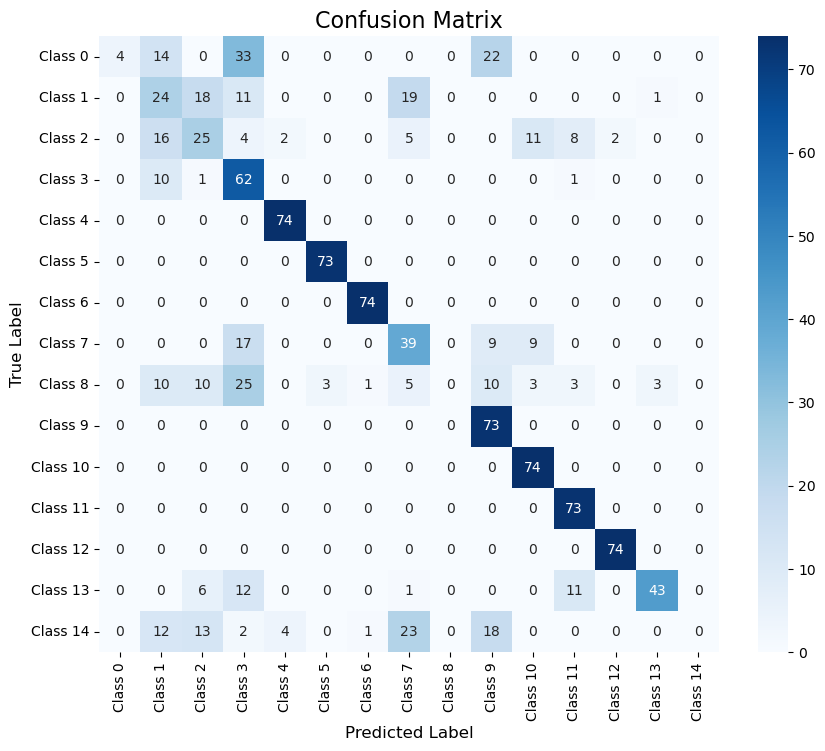

In [36]:
# 6. Evaluation Metrics
# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_mapped, target_names=[f"Class {i}" for i in range(15)]))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_mapped)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[f"Class {i}" for i in range(15)],
            yticklabels=[f"Class {i}" for i in range(15)])
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()

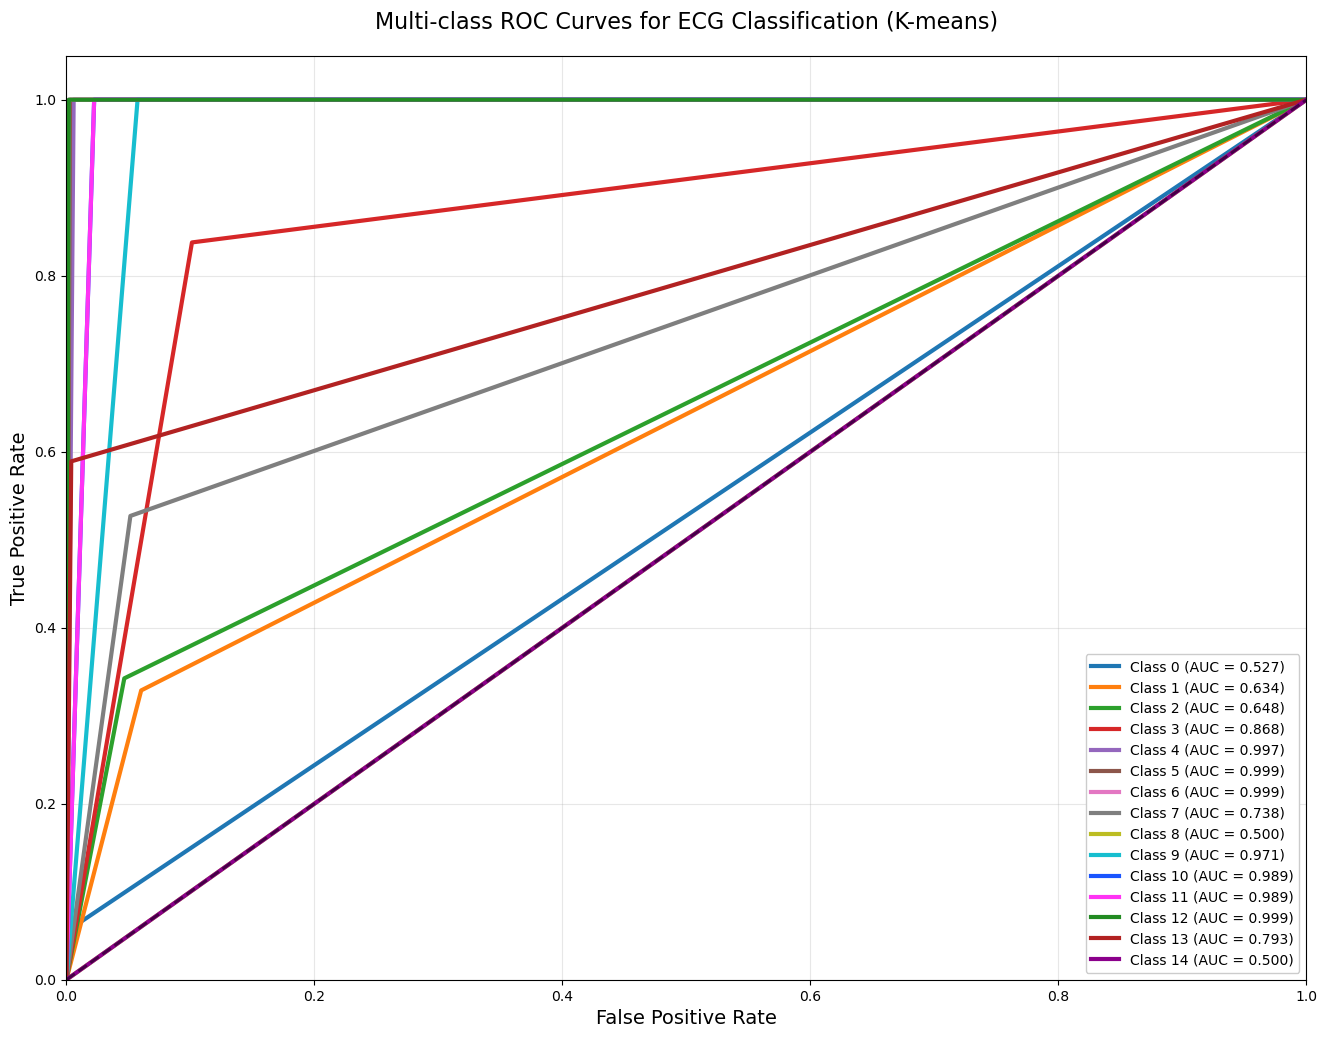

In [37]:
# 7. ROC Curves for All Classes
# Binarize the true and predicted labels for ROC calculation
y_test_bin = label_binarize(y_test, classes=range(15))
y_pred_bin = label_binarize(y_pred_mapped, classes=range(15))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(15):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(16, 12))
colors = cycle([
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
    '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
    '#1a55FF', '#FF33F4', '#228B22', '#B22222', '#8B008B'
])

for i, color in zip(range(15), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=3,
             label=f'Class {i} (AUC = {roc_auc[i]:.3f})')

# Formatting
plt.plot([0, 1], [0, 1], 'k--', lw=2, alpha=0.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Multi-class ROC Curves for ECG Classification (K-means)', fontsize=16, pad=20)
plt.legend(loc='lower right', fontsize=10, framealpha=1)
plt.grid(alpha=0.3)
plt.show()